In [1]:
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from skimage import io
import numpy as np
import cv2

def display(image, size=5):
    plt.figure(figsize=(size, size))
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

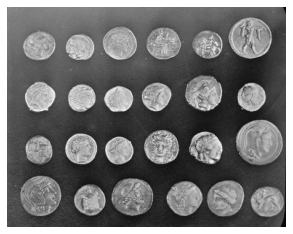

(0.0, 256.0)

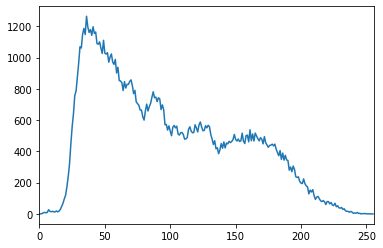

In [2]:
base_image = data.coins().astype(np.uint8)
display(base_image)

hist = cv2.calcHist([base_image], [0], None, [256], [0, 256])
plt.plot(hist)
plt.xlim([0, 256])

# Threshold image

Theory [source](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29)
* Histogram shape-based methods, where, for example, the peaks, valleys and curvatures of the smoothed histogram are analyzed
* Clustering-based methods, where the gray-level samples are clustered in two parts as background and foreground (object), or alternately are modeled as a mixture of two Gaussians
* Entropy-based methods result in algorithms that use the entropy of the foreground and background regions, the cross-entropy between the original and binarized image, etc.
* Object Attribute-based methods search a measure of similarity between the gray-level and the binarized images, such as fuzzy shape similarity, edge coincidence, etc.
* Spatial methods use higher-order probability distribution and/or correlation between pixels
* Local methods adapt the threshold value on each pixel to the local image characteristics. In these methods, a different T is selected for each pixel in the image.

## Basic

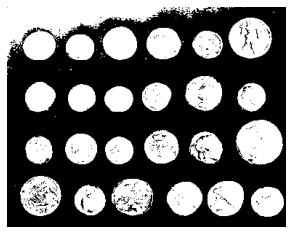

In [3]:
def threshold_basic(image):
    image = np.where(image < 110, 0, image)
    image = np.where(image >= 110, 255, image)
    return image

base_image = data.coins().astype(np.uint8)
thres_basic = threshold_basic(base_image)
display(thres_basic)

## Skimage thresholds

[source](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html#sphx-glr-auto-examples-applications-plot-thresholding-py)

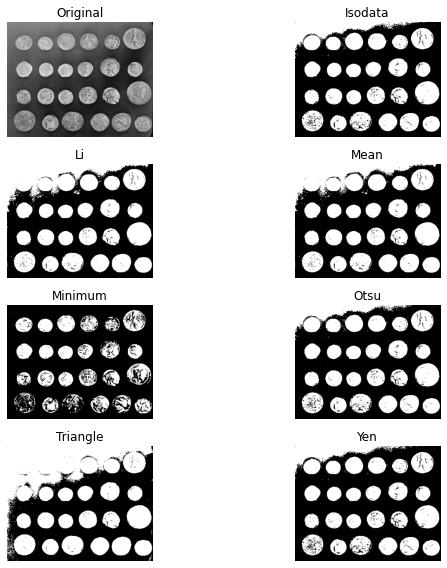

In [4]:
from skimage.filters import try_all_threshold

base_image = data.coins().astype(np.uint8)

fig, ax = try_all_threshold(base_image, figsize=(10, 8), verbose=False)
plt.show()

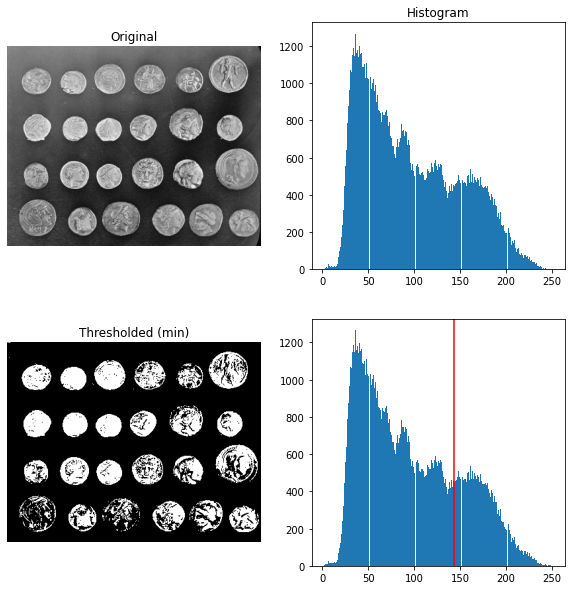

In [5]:
from skimage.filters import threshold_minimum

thresh_value = threshold_minimum(base_image)
thres_min = base_image > thresh_value

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(base_image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(base_image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(thres_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(base_image.ravel(), bins=256)
ax[1, 1].axvline(thresh_value, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

# Basic operations: theory


* Dilation : expands the ones in the image -> fills holes and gaps, grows borders
* Erosion : shrinks the shape -> unconnects components, shrinks borders

Both operations need a _structuring element_ which is a king of shape mask, which will be used for computing the maths. The structuring element is a matrix with ones and zeros, and an _origin_. We compute dilations and erosion as such :

* Dilation : We make the structuring element, centered over the origin go over the image matrix. For each pixel (with the origin of the structuring element on top), we check if we have **at least a one of the structuring element over a one** of the part of the image it currently covers (we consider that when we go over the borders of the image, the values are 0). If we have at least a one in common, then the result of dilation operation for that pixel is a one. Else, it's a 0.

* Erosion : We make the structuring element, centered over the origin go over the image matrix. For each pixel (with the origin of the structuring element on top), we check if **all the ones in the structuring element coincidate with ones** in the part of the image it currently covers (we consider that when we go over the borders of the image, the values are 0). If that's the case, then the result of erosion operation for that pixel is a one. Else, it's a 0.

## Further operations

* Opening: First erosion, then dilation.
* Closing: First dilation, then erosion.

# Custom implementations

In [9]:
import numpy as np
from skimage.morphology import disk

structuring_elt = {
    'shape': (9,9),
    'origin': (4,4),
    'data': disk(4)}

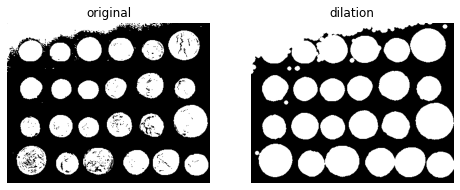

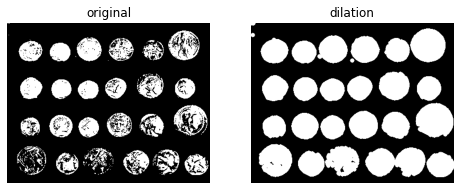

In [10]:
def dilate_custom(image, struct):
    h,w = image.shape
    offset_h_begin = struct['origin'][0]
    offset_h_end = (struct['shape'][0]-1)-struct['origin'][0]
    offset_w_begin = struct['origin'][1]
    offset_w_end = (struct['shape'][1]-1)-struct['origin'][1]
    image_padded = np.pad(image, ((offset_h_begin, offset_h_end), (offset_w_begin, offset_w_end)), 'constant', constant_values=0)
    
    dilated_image = np.zeros((h,w))
    
    for i in range(offset_h_begin, offset_h_begin+h):
        for j in range(offset_w_begin, offset_w_begin+w):
            res = True in np.unique(
                np.logical_and(
                    image_padded[i-offset_h_begin:i+offset_h_end+1, j-offset_w_begin:j+offset_w_end+1],
                    struct['data']
                ).flatten()
            )
            dilated_image[i-offset_h_begin, j-offset_w_begin] = int(res)
    return dilated_image

dilated_basic = dilate_custom(thres_basic, structuring_elt)
plot_comparison(thres_basic, dilated_basic, 'dilation')

dilated_min = dilate_custom(thres_min, structuring_elt)
plot_comparison(thres_min, dilated_min, 'dilation')

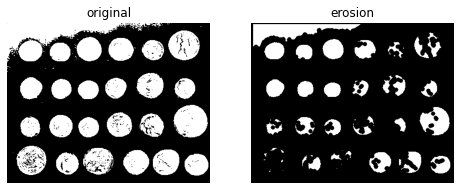

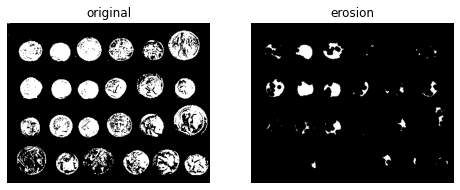

In [11]:
def erode_custom(image, struct):
    h,w = image.shape
    offset_h_begin = struct['origin'][0]
    offset_h_end = (struct['shape'][0]-1)-struct['origin'][0]
    offset_w_begin = struct['origin'][1]
    offset_w_end = (struct['shape'][1]-1)-struct['origin'][1]
    image_padded = np.pad(image, ((offset_h_begin, offset_h_end), (offset_w_begin, offset_w_end)), 'constant', constant_values=0)
    
    eroded_image = np.zeros((h,w))
    
    num_ones_struct = np.sum(struct['data'])
    
    for i in range(offset_h_begin, offset_h_begin+h):
        for j in range(offset_w_begin, offset_w_begin+w):
            res = np.sum((np.logical_and(
                    image_padded[i-offset_h_begin:i+offset_h_end+1, j-offset_w_begin:j+offset_w_end+1],
                    struct['data']
                )).astype(int))
            eroded_image[i-offset_h_begin, j-offset_w_begin] = int(res == num_ones_struct)
    return eroded_image

dilated_basic = erode_custom(thres_basic, structuring_elt)
plot_comparison(thres_basic, dilated_basic, 'erosion')

dilated_min = erode_custom(thres_min, structuring_elt)
plot_comparison(thres_min, dilated_min, 'erosion')

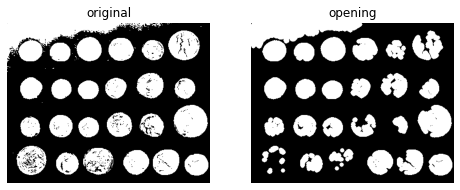

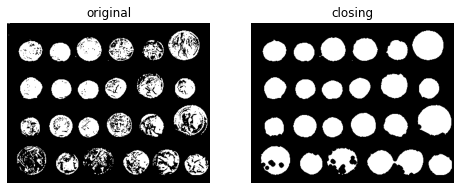

In [12]:
opened_basic = erode_custom(thres_basic, structuring_elt)
opened_basic = dilate_custom(opened_basic, structuring_elt)
plot_comparison(thres_basic, opened_basic, 'opening')

closed_min = dilate_custom(thres_min, structuring_elt)
closed_min = erode_custom(closed_min, structuring_elt)
plot_comparison(thres_min, closed_min, 'closing')

# Avec Skimage


[Documentation](https://scikit-image.org/docs/dev/api/skimage.morphology.html)

[Examples](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py)

### Structuring elements :
* ball
* cube
* diamond
* disk
* octagon
* octahedron
* rectangle
* square
* star

### Functions :

On binary images, use `binary_xx` for faster results.
On grayscale images, use normal fonctions.

In [13]:
from skimage.morphology import disk, square, diamond, octagon, rectangle

structuring_elt = disk(4)

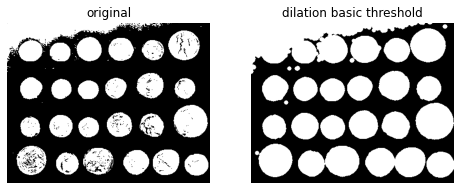

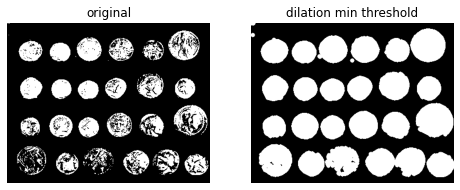

In [17]:
from skimage.morphology import disk
from skimage.morphology import binary_dilation

dilated_basic = binary_dilation(thres_basic, structuring_elt)
plot_comparison(thres_basic, dilated_basic, 'dilation basic threshold')

dilated_min = binary_dilation(thres_min, structuring_elt)
plot_comparison(thres_min, dilated_min, 'dilation min threshold')

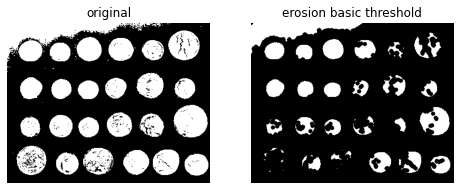

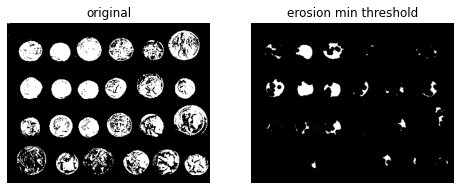

In [18]:
from skimage.morphology import binary_erosion

eroded_basic = binary_erosion(thres_basic, structuring_elt)
plot_comparison(thres_basic, eroded_basic, 'erosion basic threshold')

eroded_min = binary_erosion(thres_min, structuring_elt)
plot_comparison(thres_min, eroded_min, 'erosion min threshold')

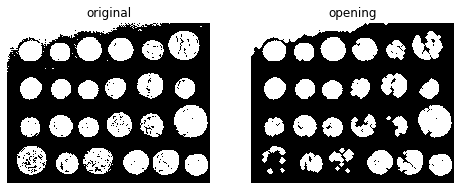

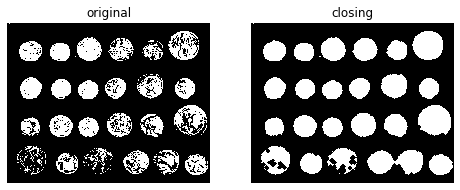

In [64]:
from skimage.morphology import binary_opening, binary_closing

opened_basic = binary_opening(thres_basic, structuring_elt)
plot_comparison(thres_basic, opened_basic, 'opening')

closed_min = binary_closing(thres_min, structuring_elt)
plot_comparison(thres_min, closed_min, 'closing')

On remarque visuellement qu'on a bien les mêmes résultats qu'avec les fonctions "custom" !
On remarque également que le résultat dépend du thresholding, et donc que choisir plutôt opening que closing dépend de l'aspect de l'image binaire que l'on a en entrée.

# In Grayscale

(872, 1000)


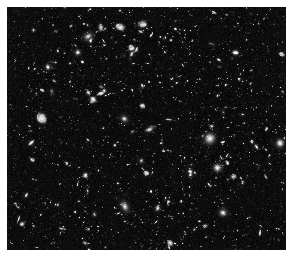

In [66]:
# images : hubble_deep_field, coffee, page, moon, microaneurysms
base_image = data.hubble_deep_field().astype(np.uint8)
if len(base_image.shape)>2:
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
print(base_image.shape)
display(base_image)

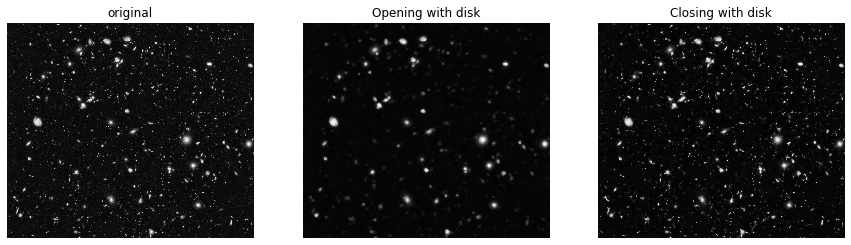

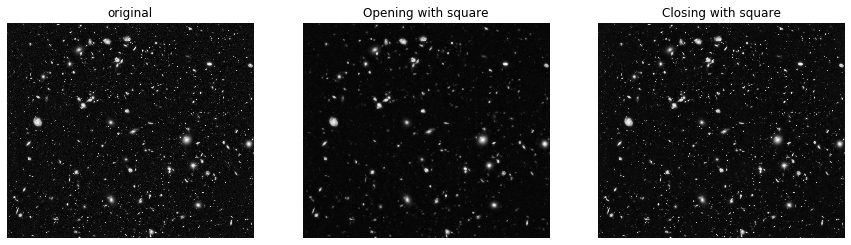

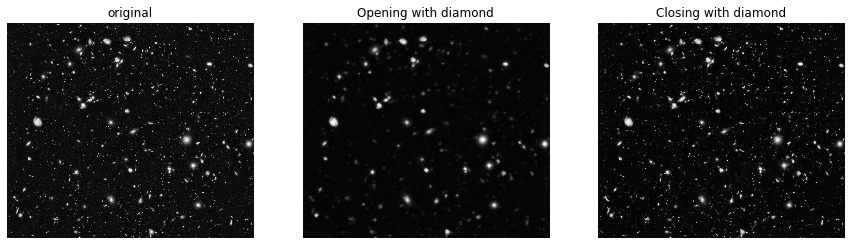

In [67]:
from skimage.morphology import opening, closing

for elt, name in [(disk(4),"disk"),(square(4),"square"), (diamond(4),"diamond")]:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True,
                                   sharey=True)
    ax1.imshow(base_image, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(opening(base_image,elt), cmap=plt.cm.gray)
    ax2.set_title('Opening with %s'%name)
    ax2.axis('off')
    ax3.imshow(closing(base_image,elt), cmap=plt.cm.gray)
    ax3.set_title('Closing with %s'%name)
    ax3.axis('off')

# Thinning

The thinning operation derives from *hit_and_miss*  
`thin(image, struct_elt) = image - hit_and_miss(image, struct_elt)`  
details on hit_and_miss : https://homepages.inf.ed.ac.uk/rbf/HIPR2/hitmiss.htm

Skeletonization is done by performing successive thinnings with structuring elements for edges and corners which we rotate every time (https://homepages.inf.ed.ac.uk/rbf/HIPR2/thin.htm) : 4 (orientations) x 2 (edge + corner) operations with different structuring elements at least, which we repeat until no further change in the image is observed.

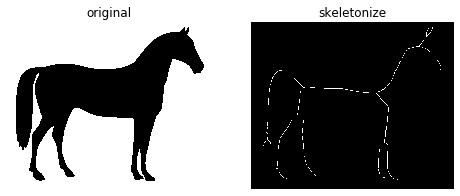

In [44]:
from skimage.morphology import skeletonize

horse = data.horse()

sk = skeletonize(horse == 0)
plot_comparison(horse, sk, 'skeletonize')

# Bounding box

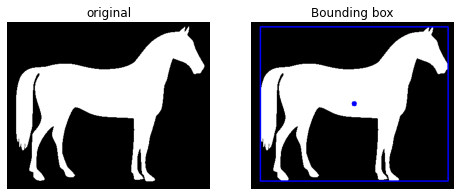

In [42]:
mask = np.logical_not(data.horse())
i, j = np.where(mask)

mask = np.uint8(mask*255) # convert boolean array of horse to 0-255
img = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
_ = cv2.rectangle(img, (min(j), min(i)), (max(j), max(i)), (0, 0, 255), 2) # bbox
cX = min(i) + (max(i) - min(i))//2
cY = min(j) + (max(j) - min(j))//2
_ = cv2.circle(img, (cY, cX), 5, (0, 0, 255), -1) # center

plot_comparison(mask, img, 'Bounding box')

# Barycenter / center of mass

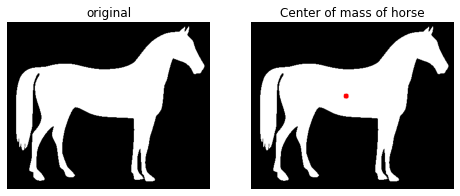

In [43]:
# calculate moments of binary image
M = cv2.moments(mask)

# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

img = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
# highlight the barycenter
_ = cv2.circle(img, (cX, cY), 5, (255, 0, 0), -1)

plot_comparison(mask, img, 'Center of mass of horse')